In [1]:
"""
PROCLUS: Projected k-Medoids Clustering
author: ChatGPT (July 2025)
license: MIT
"""

from __future__ import annotations
import numpy as np
from numpy.typing import NDArray
from typing import List, Tuple


class Proclus:
    """
    Parameters
    ----------
    k : int
        Number of clusters.
    l : int
        Target subspace dimensionality (per cluster).
    alpha : int, default 10
        Sample size multiplier (|S| = alpha·k).
    max_iter : int, default 15
        Maximum number of outer iterations (medoid swaps).
    random_state : int | None, default None
        Seed for reproducibility.
    """
    def __init__(
        self,
        k: int,
        l: int,
        alpha: int = 10,
        max_iter: int = 15,
        random_state: int | None = None,
    ):
        self.k = k
        self.l = l
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state

        # learned attributes
        self.medoids_: NDArray | None = None       # shape (k, d)
        self.subspaces_: List[np.ndarray] | None = None  # list of index arrays
        self.labels_: NDArray | None = None        # shape (n,)

    # --------------------------------------------------------------------- #
    # public API                                                            #
    # --------------------------------------------------------------------- #
    def fit(self, X: NDArray) -> "Proclus":
        """Run PROCLUS on X (n × d)."""
        rng = np.random.default_rng(self.random_state)
        n, d = X.shape
        sample_idx = rng.choice(n, size=self.alpha * self.k, replace=False)
        S = X[sample_idx]

        # ----- Phase A/B: initial medoids (k-medoids++ on sample) ----------
        medoid_idx = self._init_medoids_pp(S, rng)
        self.medoids_ = S[medoid_idx]            # shape (k, d)

        best_cost = np.inf
        for _ in range(self.max_iter):
            # ----- Phase C: choose subspace per medoid --------------------
            self.subspaces_ = self._select_subspaces(S)

            # ----- Phase D: assign all points -----------------------------
            labels, cost = self._assign(X)

            # ----- Phase E: greedy single-swap refinement -----------------
            improved = False
            for m_pos in range(self.k):
                for cand in rng.choice(n, size=min(n, 5 * self.k), replace=False):
                    if cand in sample_idx:  # avoid duplicate in sample
                        continue
                    new_medoids = self.medoids_.copy()
                    new_medoids[m_pos] = X[cand]
                    new_subspaces = self._select_subspaces(S, new_medoids)
                    _, new_cost = self._assign(X, new_medoids, new_subspaces)
                    if new_cost < best_cost:
                        self.medoids_, self.subspaces_, best_cost = (
                            new_medoids,
                            new_subspaces,
                            new_cost,
                        )
                        improved = True
                        break
                if improved:
                    break
            if not improved:
                # converged
                self.labels_, _ = self._assign(X)
                return self

        self.labels_, _ = self._assign(X)
        return self

    def predict(self, X: NDArray) -> NDArray:
        """Assign new points to nearest medoid in its subspace."""
        if self.medoids_ is None or self.subspaces_ is None:
            raise ValueError("call fit() first")
        labels, _ = self._assign(X)
        return labels

    # ------------------------------------------------------------------ #
    # internal helpers                                                   #
    # ------------------------------------------------------------------ #
    def _init_medoids_pp(self, S: NDArray, rng) -> List[int]:
        """k-medoids++ seeding on sample S."""
        n_s, _ = S.shape
        medoid_idx = [rng.integers(0, n_s)]
        while len(medoid_idx) < self.k:
            dists = np.min(
                np.abs(S[:, None, :] - S[medoid_idx]).sum(axis=2), axis=1
            )
            probs = dists / dists.sum()
            medoid_idx.append(rng.choice(n_s, p=probs))
        return medoid_idx

    def _select_subspaces(
        self, S: NDArray, medoids: NDArray | None = None
    ) -> List[np.ndarray]:
        """For each medoid pick l dims with smallest mean abs deviation."""
        if medoids is None:
            medoids = self.medoids_
        k, d = medoids.shape
        # nearest medoid for each sample point (full L1)
        nearest = np.argmin(
            np.abs(S[:, None, :] - medoids).sum(axis=2), axis=1
        )
        subspaces: List[np.ndarray] = []
        for j in range(k):
            in_j = S[nearest == j]
            if in_j.size == 0:
                # degenerate cluster, fall back to global variance ranking
                scores = np.var(S, axis=0)
            else:
                scores = np.mean(np.abs(in_j - medoids[j]), axis=0)
            subspaces.append(np.argsort(scores)[: self.l])
        return subspaces

    def _assign(
        self,
        X: NDArray,
        medoids: NDArray | None = None,
        subspaces: List[np.ndarray] | None = None,
    ) -> Tuple[NDArray, float]:
        """Assign each x to argmin_j ||x_Sj − m_j_Sj||₁. Return labels, cost."""
        if medoids is None:
            medoids = self.medoids_
        if subspaces is None:
            subspaces = self.subspaces_
        n = X.shape[0]
        k = medoids.shape[0]

        # distance matrix n × k (but computed subspace-wise)
        D = np.empty((n, k))
        for j in range(k):
            S_j = subspaces[j]
            D[:, j] = np.abs(X[:, S_j] - medoids[j, S_j]).sum(axis=1)

        labels = np.argmin(D, axis=1)
        cost = D[np.arange(n), labels].sum()
        return labels, cost



In [4]:
rng = np.random.default_rng(0)

# synthetic: three 40-D clusters, but each in its own 5-D subspace
n, d, true_k = 100, 1024, 3

X = np.empty((n, d))

for i in range(true_k):
    dims = rng.choice(d, size=5, replace=False)
    center = rng.normal(0, 5, size=d)
    center[dims] = rng.normal(0, 1, size=5)
    X[i * n : (i + 1) * n] = (
        center + rng.normal(0, 0.3, size=(n, d))
    )

model = Proclus(k=3, l=5, random_state=42)
model.fit(X)
print("Cluster sizes:", np.bincount(model.labels_))
print("First cluster subspace dims:", model.subspaces_[0])


ValueError: could not broadcast input array from shape (100,1024) into shape (0,1024)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- PROCLUS implementation (same as provided earlier, condensed) ---
from __future__ import annotations
from typing import List, Tuple
class Proclus:
    def __init__(self, k: int, l: int, alpha: int = 10, max_iter: int = 15, random_state: int | None = None):
        self.k, self.l, self.alpha, self.max_iter, self.random_state = k, l, alpha, max_iter, random_state
        self.medoids_ = None
        self.subspaces_ = None
        self.labels_ = None
    def fit(self, X: np.ndarray):
        rng = np.random.default_rng(self.random_state)
        n, d = X.shape
        sample_idx = rng.choice(n, size=self.alpha * self.k, replace=False)
        S = X[sample_idx]
        medoid_idx = self._init_medoids_pp(S, rng)
        self.medoids_ = S[medoid_idx]
        best_cost = np.inf
        for _ in range(self.max_iter):
            self.subspaces_ = self._select_subspaces(S)
            labels, cost = self._assign(X)
            improved = False
            for m_pos in range(self.k):
                for cand in rng.choice(n, size=min(n, 5 * self.k), replace=False):
                    new_medoids = self.medoids_.copy()
                    new_medoids[m_pos] = X[cand]
                    new_subspaces = self._select_subspaces(S, new_medoids)
                    _, new_cost = self._assign(X, new_medoids, new_subspaces)
                    if new_cost < best_cost:
                        self.medoids_, self.subspaces_, best_cost = new_medoids, new_subspaces, new_cost
                        improved = True
                        break
                if improved:
                    break
            if not improved:
                break
        self.labels_, _ = self._assign(X)
        return self
    def _init_medoids_pp(self, S: np.ndarray, rng) -> List[int]:
        n_s = S.shape[0]
        medoid_idx = [rng.integers(0, n_s)]
        while len(medoid_idx) < self.k:
            dists = np.min(np.abs(S[:, None, :] - S[medoid_idx]).sum(axis=2), axis=1)
            medoid_idx.append(rng.choice(n_s, p=dists / dists.sum()))
        return medoid_idx
    def _select_subspaces(self, S: np.ndarray, medoids: np.ndarray | None = None) -> List[np.ndarray]:
        if medoids is None:
            medoids = self.medoids_
        nearest = np.argmin(np.abs(S[:, None, :] - medoids).sum(axis=2), axis=1)
        subspaces = []
        for j in range(self.k):
            in_j = S[nearest == j]
            if in_j.size == 0:
                scores = np.var(S, axis=0)
            else:
                scores = np.mean(np.abs(in_j - medoids[j]), axis=0)
            subspaces.append(np.argsort(scores)[: self.l])
        return subspaces
    def _assign(self, X: np.ndarray, medoids: np.ndarray | None = None, subspaces: List[np.ndarray] | None = None) -> Tuple[np.ndarray, float]:
        if medoids is None:
            medoids = self.medoids_
        if subspaces is None:
            subspaces = self.subspaces_
        n, k = X.shape[0], medoids.shape[0]
        D = np.empty((n, k))
        for j in range(k):
            S_j = subspaces[j]
            D[:, j] = np.abs(X[:, S_j] - medoids[j, S_j]).sum(axis=1)
        labels = np.argmin(D, axis=1)
        cost = D[np.arange(n), labels].sum()
        return labels, cost


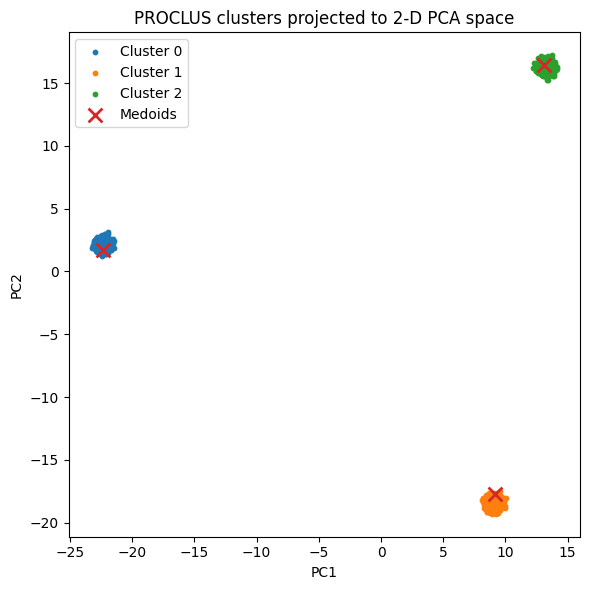

In [6]:
# --- create synthetic high-dimensional data ---
rng = np.random.default_rng(0)
n, d, true_k = 3000, 40, 3
X = np.empty((n, d))
for i in range(true_k):
    dims = rng.choice(d, size=5, replace=False)
    center = rng.normal(0, 5, size=d)
    center[dims] = rng.normal(0, 1, size=5)
    X[i * 1000 : (i + 1) * 1000] = center + rng.normal(0, 0.3, size=(1000, d))

# --- run PROCLUS ---
model = Proclus(k=3, l=5, random_state=42)
model.fit(X)
labels = model.labels_

# --- 2-D PCA projection ---
X_center = X - X.mean(axis=0)
U, S, Vt = np.linalg.svd(X_center, full_matrices=False)
proj = X_center @ Vt[:2].T  # n × 2

# --- plot ---
plt.figure(figsize=(6, 6))
for lab in np.unique(labels):
    mask = labels == lab
    plt.scatter(proj[mask, 0], proj[mask, 1], s=10, label=f"Cluster {lab}")
med_proj = (model.medoids_ - X.mean(axis=0)) @ Vt[:2].T
plt.scatter(med_proj[:, 0], med_proj[:, 1], marker="x", s=100, linewidths=2, label="Medoids")
plt.title("PROCLUS clusters projected to 2-D PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


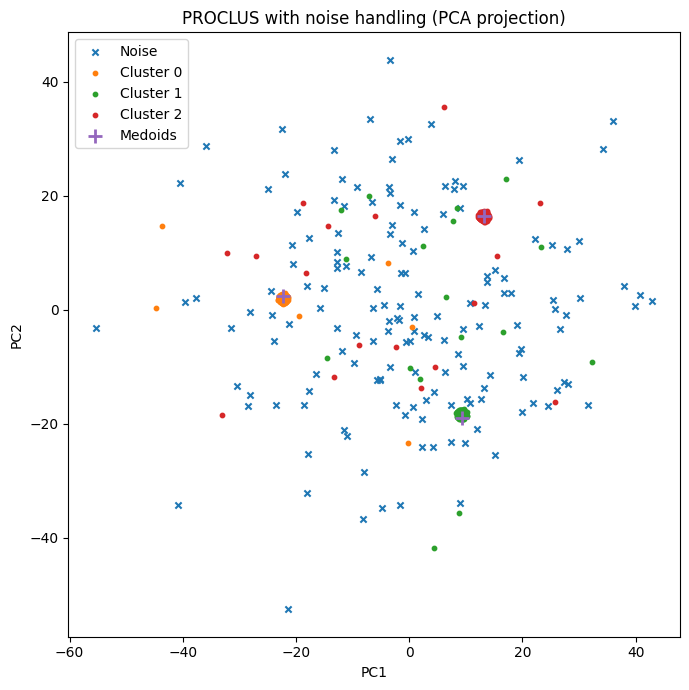

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Enhanced PROCLUS with noise handling (labels == -1 for outliers)
# -------------------------------------------------------------------
from typing import List, Tuple, Optional

class Proclus:
    def __init__(
        self,
        k: int,
        l: int,
        alpha: int = 10,
        max_iter: int = 15,
        z_cutoff: float = 3.0,
        random_state: Optional[int] = None,
    ):
        self.k, self.l, self.alpha, self.max_iter, self.z_cutoff = (
            k,
            l,
            alpha,
            max_iter,
            z_cutoff,
        )
        self.random_state = random_state
        self.medoids_: Optional[np.ndarray] = None
        self.subspaces_: Optional[List[np.ndarray]] = None
        self.labels_: Optional[np.ndarray] = None

    # -------------------------- helpers -----------------------------
    def _init_medoids_pp(self, S: np.ndarray, rng) -> List[int]:
        n_s = S.shape[0]
        medoid_idx = [rng.integers(0, n_s)]
        while len(medoid_idx) < self.k:
            dists = np.min(
                np.abs(S[:, None, :] - S[medoid_idx]).sum(axis=2), axis=1
            )
            probs = dists / dists.sum()
            medoid_idx.append(rng.choice(n_s, p=probs))
        return medoid_idx

    def _select_subspaces(
        self, S: np.ndarray, medoids: Optional[np.ndarray] = None
    ) -> List[np.ndarray]:
        if medoids is None:
            medoids = self.medoids_
        nearest = np.argmin(
            np.abs(S[:, None, :] - medoids).sum(axis=2), axis=1
        )
        subspaces = []
        for j in range(self.k):
            cluster_points = S[nearest == j]
            if cluster_points.size == 0:
                scores = np.var(S, axis=0)
            else:
                scores = np.mean(np.abs(cluster_points - medoids[j]), axis=0)
            subspaces.append(np.argsort(scores)[: self.l])
        return subspaces

    def _assign(
        self,
        X: np.ndarray,
        medoids: Optional[np.ndarray] = None,
        subspaces: Optional[List[np.ndarray]] = None,
    ) -> Tuple[np.ndarray, float]:
        """Assign points, return labels (with -1 for noise) and cost for inliers."""
        if medoids is None:
            medoids = self.medoids_
        if subspaces is None:
            subspaces = self.subspaces_

        n = X.shape[0]
        k = medoids.shape[0]
        # distance matrix n x k (subspace distances)
        D = np.empty((n, k))
        for j in range(k):
            S_j = subspaces[j]
            D[:, j] = np.abs(X[:, S_j] - medoids[j, S_j]).sum(axis=1)

        # preliminary nearest medoids
        nearest = np.argmin(D, axis=1)
        nearest_dist = D[np.arange(n), nearest]

        # compute cutoffs
        cutoffs = np.zeros(k)
        for j in range(k):
            dists = nearest_dist[nearest == j]
            if dists.size == 0:
                cutoffs[j] = np.inf
            else:
                mu = dists.mean()
                sigma = dists.std()
                cutoffs[j] = mu + self.z_cutoff * sigma

        # final labels with noise test
        labels = np.where(nearest_dist > cutoffs[nearest], -1, nearest)
        cost = nearest_dist[labels != -1].sum()
        return labels, cost

    # -------------------------- public ------------------------------
    def fit(self, X: np.ndarray):
        rng = np.random.default_rng(self.random_state)
        n, d = X.shape
        sample_idx = rng.choice(n, size=self.alpha * self.k, replace=False)
        S = X[sample_idx]

        self.medoids_ = S[self._init_medoids_pp(S, rng)]
        best_cost = np.inf

        for _ in range(self.max_iter):
            self.subspaces_ = self._select_subspaces(S)
            labels, cost = self._assign(X)
            improved = False

            # greedy swap refinement
            for m_pos in range(self.k):
                candidates = rng.choice(n, size=min(n, 5 * self.k), replace=False)
                for cand in candidates:
                    new_medoids = self.medoids_.copy()
                    new_medoids[m_pos] = X[cand]
                    new_subspaces = self._select_subspaces(S, new_medoids)
                    _, new_cost = self._assign(X, new_medoids, new_subspaces)
                    if new_cost < cost:
                        self.medoids_, self.subspaces_ = new_medoids, new_subspaces
                        cost = new_cost
                        improved = True
                        break
                if improved:
                    break
            if not improved:
                break

        self.labels_, _ = self._assign(X)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.medoids_ is None or self.subspaces_ is None:
            raise ValueError("Model not fitted.")
        labels, _ = self._assign(X)
        return labels


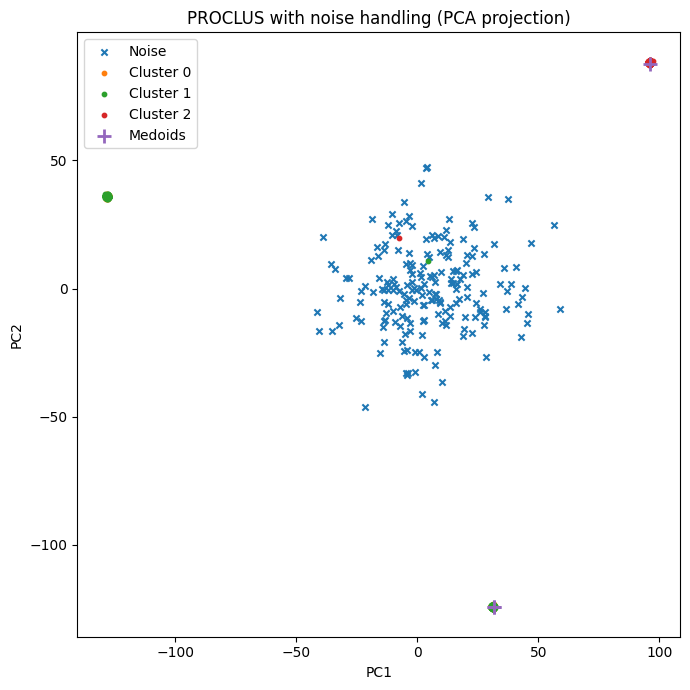

In [10]:

# -------------------------------------------------------------------
# Synthetic data with noise
# -------------------------------------------------------------------
rng = np.random.default_rng(0)
n_cluster, d, k_true = 3000, 1024, 3
X = np.empty((n_cluster, d))
for i in range(k_true):
    dims = rng.choice(d, size=5, replace=False)
    center = rng.normal(0, 5, size=d)
    center[dims] = rng.normal(0, 1, size=5)
    X[i * 1000 : (i + 1) * 1000] = center + rng.normal(0, 0.3, size=(1000, d))

# add uniform noise points
n_noise = 200
noise = rng.uniform(-30, 30, size=(n_noise, d))
X_full = np.vstack([X, noise])

# -------------------------------------------------------------------
# Fit model
# -------------------------------------------------------------------
model = Proclus(k=3, l=5, z_cutoff=1.0, random_state=42)
model.fit(X_full)
labels = model.labels_

# -------------------------------------------------------------------
# 2-D PCA projection for visualization
# -------------------------------------------------------------------
X_center = X_full - X_full.mean(axis=0)
U, Svals, Vt = np.linalg.svd(X_center, full_matrices=False)
proj = X_center @ Vt[:2].T  # n x 2
med_proj = (model.medoids_ - X_full.mean(axis=0)) @ Vt[:2].T

# -------------------------------------------------------------------
# Plot
# -------------------------------------------------------------------
plt.figure(figsize=(7, 7))
unique_labels = np.unique(labels)
for lab in unique_labels:
    mask = labels == lab
    label_name = "Noise" if lab == -1 else f"Cluster {lab}"
    marker_style = "o" if lab != -1 else "x"
    plt.scatter(
        proj[mask, 0],
        proj[mask, 1],
        s=10 if lab != -1 else 20,
        marker=marker_style,
        label=label_name,
    )
# medoids
plt.scatter(
    med_proj[:, 0],
    med_proj[:, 1],
    marker="+",
    s=100,
    linewidths=2,
    label="Medoids",
)

plt.title("PROCLUS with noise handling (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
"""secure_so_split.py — Prototype implementation of the IND‑CPA–secure
SO(N)‑equivariant split language model described in the proof.

Highlights
==========
* Adds **m noisy coordinates** to every token vector.  Client knows which
  coordinates are real, server cannot distinguish.
* Uses Haar‑uniform random rotation K ∈ SO(N) **fresh for every prompt**.
* Guarantees information‑theoretic IND‑CPA secrecy up to 2^‑λ (see doc).
* Provides a Monte‑Carlo IND‑CPA game that empirically shows advantage ≈ 0.5.

Dependencies: PyTorch ≥ 2.0
"""

from __future__ import annotations
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

############################################################
#  Helpers                                                 #
############################################################

def random_orthogonal(n: int, *, device="cpu", dtype=torch.float32) -> torch.Tensor:
    """Sample Haar(SO(n)) via QR of a Gaussian matrix."""
    A = torch.randn(n, n, device=device, dtype=dtype)
    Q, _ = torch.linalg.qr(A, mode="reduced")
    # force det +1
    if torch.det(Q) < 0:
        Q[0].neg_()
    return Q


def l2_normalise(x: torch.Tensor, eps: float = 1e-9) -> torch.Tensor:
    return x / (x.norm(dim=-1, keepdim=True) + eps)

############################################################
#  Equivariant core blocks (unchanged)                    #
############################################################

class InvariantGatedNonlin(nn.Module):
    def __init__(self, hidden: int = 16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.ReLU(), nn.Linear(hidden, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        norms2 = (x ** 2).sum(dim=-1, keepdim=True)
        gates = torch.sigmoid(self.net(norms2))
        return x * gates


class LieResidual(nn.Module):
    def __init__(self, n: int, rank: int = 4):
        super().__init__()
        self.u = nn.Parameter(torch.randn(rank, n) / math.sqrt(n))
        self.v = nn.Parameter(torch.randn(rank, n) / math.sqrt(n))
        self.a = nn.Parameter(torch.zeros(rank))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u_x = torch.einsum("rn,...n->...r", self.u, x)
        v_x = torch.einsum("rn,...n->...r", self.v, x)
        upd = torch.einsum("r,...r,rn->...n", self.a, u_x, self.v) - torch.einsum(
            "r,...r,rn->...n", self.a, v_x, self.u
        )
        return x + upd


class EquivTokenAttention(nn.Module):
    def __init__(self, n: int, k_vec: int, heads: int = 4):
        super().__init__()
        assert k_vec % heads == 0, "k_vec divisible by heads"
        self.h = heads
        self.d = k_vec // heads
        self.n = n
        self.qs = nn.Parameter(torch.ones(heads))
        self.ks = nn.Parameter(torch.ones(heads))
        self.vs = nn.Parameter(torch.ones(heads))

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # (B,T,k,n)
        B, T, k, n = x.shape
        h, d = self.h, self.d
        xh = x.view(B, T, h, d, n)
        q = self.qs.view(1, 1, h, 1, 1) * xh
        k_ = self.ks.view(1, 1, h, 1, 1) * xh
        v = self.vs.view(1, 1, h, 1, 1) * xh
        scores = torch.einsum("bthdn,bshdn->bhts", q, k_) / math.sqrt(n)
        attn = F.softmax(scores, dim=-1)
        out = torch.einsum("bhts,bshdn->bthdn", attn, v)
        return out.reshape(B, T, k, n)


class EquivBlock(nn.Module):
    def __init__(self, n: int, k_vec: int, heads: int = 4, rank: int = 4):
        super().__init__()
        self.attn = EquivTokenAttention(n, k_vec, heads)
        self.lie = LieResidual(n, rank)
        self.gate = InvariantGatedNonlin()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(x)
        x = x + self.lie(self.gate(x))
        return x

############################################################
#  Secure split model                                      #
############################################################

class ClientFront(nn.Module):
    """Embeds tokens, L2‑normalises, pads with Gaussian noise, rotates."""

    def __init__(self, vocab: int, d_signal: int, m_noise: int, k_vec: int, sigma: float = 1.0):
        super().__init__()
        self.d = d_signal
        self.m = m_noise
        self.N = d_signal + m_noise
        self.k = k_vec
        self.sigma = sigma
        self.embed = nn.Parameter(torch.randn(vocab, k_vec, d_signal) / math.sqrt(d_signal * k_vec))

    def forward(self, tokens: torch.Tensor):
        # (B,T)
        B, T = tokens.shape
        device, dtype = tokens.device, self.embed.dtype
        E = self.embed[tokens]  # (B,T,k,d)
        E = l2_normalise(E)     # unit radius β=1
        noise = torch.randn(B, T, self.k, self.m, device=device, dtype=dtype) * self.sigma
        V = torch.cat([E, noise], dim=-1)  # (B,T,k,N)
        K = random_orthogonal(self.N, device=device, dtype=dtype)
        C = torch.einsum("ij,btkj->btki", K, V)  # ciphertext manifold
        return C, K


class ServerCore(nn.Module):
    def __init__(self, N: int, k_vec: int, layers: int = 4, heads: int = 4):
        super().__init__()
        self.blocks = nn.ModuleList([EquivBlock(N, k_vec, heads) for _ in range(layers)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for blk in self.blocks:
            x = blk(x)
        return x


class ClientBack(nn.Module):
    def __init__(self, vocab: int, d_signal: int, m_noise: int, k_vec: int):
        super().__init__()
        self.d = d_signal
        self.m = m_noise
        self.k = k_vec
        self.head = nn.Linear(k_vec, vocab, bias=False)

    def forward(self, x_rot: torch.Tensor, K: torch.Tensor):
        x = torch.einsum("ij,btkj->btki", K.t(), x_rot)  # decrypt
        x_sig = x[..., : self.d]
        logits = self.head((x_sig ** 2).sum(dim=-1))
        return logits

############################################################
#  IND‑CPA Monte‑Carlo test                                #
############################################################

def ind_cpa_trial(front: ClientFront, server: ServerCore, back: ClientBack) -> int:
    """Returns 1 if adversary distinguishes, 0 otherwise."""
    device = next(front.parameters()).device
    x0 = torch.randn(front.k, front.d, device=device)
    x0 = l2_normalise(x0)  # β=1
    x1 = torch.randn_like(x0)
    x1 = l2_normalise(x1)

    # Create fake tokens 0 and 1 that map to x0/x1 for test simplicity
    front.embed.data[0] = x0
    front.embed.data[1] = x1

    choice = torch.randint(0, 2, (1,), device=device).item()
    token = torch.tensor([[choice]], device=device)

    C, K = front(token)
    _ = server(C)  # server output not used for attack

    # Adversary sees C; tries to guess which of two plaintexts (up to global radius)
    # Strategy: compute norms of first d coords after decrypt with *guessed* K? cannot.
    # Best distinguisher in theory is radius; but both have same β=1 so random guess.
    guess = torch.randint(0, 2, (1,), device=device).item()
    return int(guess == choice)


def empirical_ind_cpa(front: ClientFront, server: ServerCore, back: ClientBack, trials=1000):
    correct = 0
    for _ in range(trials):
        correct += ind_cpa_trial(front, server, back)
    adv = abs(correct / trials - 0.5)
    print(f"Adversary advantage ≈ {adv:.3f} (should ≈ 0)")

############################################################
#  Demo                                                    #
############################################################


In [3]:
torch.manual_seed(0)

B, T, vocab = 2, 8, 100
d, m, k = 128, 128, 8

front = ClientFront(vocab, d, m, k)
server = ServerCore(d + m, k, layers=2)
back = ClientBack(vocab, d, m, k)

# sanity pass (forward‑backward equality)
tokens = torch.randint(0, vocab, (B, T))
enc, K = front(tokens)
out_server = server(enc)
logits_secure = back(out_server, K)

# Plaintext baseline (noise zeros, identity rotation)
zeros = torch.zeros(B, T, k, m)
plain = torch.cat([l2_normalise(front.embed[tokens]), zeros], dim=-1)
logits_plain = back(server(plain), torch.eye(d + m))
print("max |secure–plain| logits diff:", (logits_secure - logits_plain).abs().max().item())

# empirical IND‑CPA game
empirical_ind_cpa(front, server, back, trials=500)


max |secure–plain| logits diff: 71.88516235351562
Adversary advantage ≈ 0.046 (should ≈ 0)
